# Obtain the city's landmarks according to OSM

- Large POIs: Hospitals, Universities, Train/Coach stations, Stadiums, Museums, Core Business District
- Small POIs: light rail stations, bars, pubs, 
- Land Use

In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np

import oslo_lib

ox.config(use_cache=True, log_console=True)

def get_boundaries(array):
    return min(array), max(array)

def get_spread(boundaries):
    return max(boundaries) - min(boundaries)

def get_center(spread):
    return np.mean(spread)

def get_window(center, spread, buffer):
    buffer = buffer*spread/2
    return (center - spread/2 - buffer), (center + spread/2 + buffer)

def get_windows(latitudes, longitudes, buffer):

    longitude_spread = get_spread(longitudes)
    longitude_center = get_center(longitudes)
    longitude_window = get_window(longitude_center, longitude_spread, buffer)

    latitude_spread = get_spread(latitudes)
    latitude_center = get_center(latitudes)
    latitude_window = get_window(latitude_center, latitude_spread, buffer)
    
    return latitude_window, longitude_window

def window_filter(series, window):
    f1 = series >= window[0]
    f2 = series <= window[1]    
    return (f1) & (f2)

In [ ]:
# Get street network 
G_bikes = ox.graph_from_bbox(*sorted(latitude_window, reverse=True), 
                             *sorted(longitude_window, reverse=True), 
                             network_type='bike')
G_bikes_projected = ox.project_graph(G_bikes)
oslo_crs = G_bikes_projected.graph['crs']

nodes, edges = ox.utils_graph.graph_to_gdfs(G_bikes_projected)
cycleways = edges[edges.highway.apply(lambda x : 'cycleway' in x)]
cycleway_graph = ox.utils_graph.graph_from_gdfs(nodes, cycleways)

In [63]:
bike_sharing_stations = pd.read_pickle('Oslo/stations.pkl')
bike_sharing_stations = oslo_lib.get_geostations(bike_sharing_stations).to_crs('epsg:4326')

bike_sharing_stations.longitude = bike_sharing_stations.geometry.x
bike_sharing_stations.latitude = bike_sharing_stations.geometry.y

longitude_window, latitude_window = get_windows(get_boundaries(bike_sharing_stations.longitude), 
                                                get_boundaries(bike_sharing_stations.latitude), 
                                                buffer=.1)

Oslo_bbox = [*sorted(latitude_window, reverse=True), *sorted(longitude_window, reverse=True)]

def geo_filter(df, latitude_window=latitude_window, longitude_window=longitude_window):
    lat_filter = window_filter(df.latitude, latitude_window)
    lon_filter = window_filter(df.longitude, longitude_window)
    return (lat_filter) & (lon_filter)

/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [142]:
Oslo_boundary = ox.geocode_to_gdf(['Oslo, Norway'])
land_use = ox.geometries_from_bbox(*Oslo_bbox, tags={'landuse':True})
water = ox.geometries_from_bbox(*Oslo_bbox, tags={'natural':'water'})

railway_stations = ox.geometries_from_bbox(*Oslo_bbox, tags={'railway':'station'})
railway_stations['longitude'] = railway_stations.geometry.x
railway_stations['latitude'] = railway_stations.geometry.y
print(len(railway_stations), 'railway stations')

bus_stations = ox.geometries_from_bbox(*Oslo_bbox, tags={'amenity':'bus_station'})
bus_stations.geometry = bus_stations.geometry.centroid
bus_stations['longitude'] = bus_stations.geometry.x
bus_stations['latitude'] = bus_stations.geometry.y
print(len(bus_stations), 'bus stations')

2023-07-29 22:08:10 Retrieved response from cache file "cache/6df0e46f7228add1fd192a93ddb14ffb56805856.json"
2023-07-29 22:08:10 Created GeoDataFrame with 1 rows from 1 queries
2023-07-29 22:08:10 Projected GeoDataFrame to +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2023-07-29 22:08:10 Projected GeoDataFrame to epsg:4326
2023-07-29 22:08:10 Requesting data within polygon from API in 1 request(s)
2023-07-29 22:08:10 Retrieved response from cache file "cache/8f64263a54c22cc10779c1044a434437c792f24c.json"
2023-07-29 22:08:10 Got all geometries data within polygon from API in 1 request(s)
2023-07-29 22:08:10 Converting 53902 elements in JSON responses to geometries
2023-07-29 22:08:10 3202 geometries created in the dict
2023-07-29 22:08:10 101 untagged geometries removed
2023-07-29 22:08:11 Created r-tree spatial index for 3101 geometries
2023-07-29 22:08:11 Identified 3081 geometries inside polygon
2023-07-29 22:08:11 20 geometries removed by the polygon filte

/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the len

2023-07-29 22:08:11 2634 geometries in the final GeoDataFrame
2023-07-29 22:08:11 Projected GeoDataFrame to +proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2023-07-29 22:08:11 Projected GeoDataFrame to epsg:4326
2023-07-29 22:08:11 Requesting data within polygon from API in 1 request(s)
2023-07-29 22:08:11 Retrieved response from cache file "cache/e743e6295a105df1b923ac5961214c34f572cd19.json"
2023-07-29 22:08:11 Got all geometries data within polygon from API in 1 request(s)
2023-07-29 22:08:11 Converting 4536 elements in JSON responses to geometries
2023-07-29 22:08:11 162 geometries created in the dict
2023-07-29 22:08:11 21 untagged geometries removed
2023-07-29 22:08:11 Created r-tree spatial index for 141 geometries
2023-07-29 22:08:11 Identified 141 geometries inside polygon
2023-07-29 22:08:11 0 geometries removed by the polygon filter
2023-07-29 22:08:11 14 geometries removed by the tag filter
2023-07-29 22:08:11 127 geometries in the final GeoDataFram

/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]
/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https:/

2023-07-29 22:08:11 Unrecognized server status: "Rate limit: 6"
2023-07-29 22:08:11 Pausing 60 seconds before making HTTP POST request
2023-07-29 22:09:11 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28%28node%5B%27amenity%27%3D%27bus_station%27%5D%28poly%3A%2759.895362+10.642964+59.895362+10.822353+59.956176+10.822353+59.956176+10.642964+59.895362+10.642964%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28way%5B%27amenity%27%3D%27bus_station%27%5D%28poly%3A%2759.895362+10.642964+59.895362+10.822353+59.956176+10.822353+59.956176+10.642964+59.895362+10.642964%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%28relation%5B%27amenity%27%3D%27bus_station%27%5D%28poly%3A%2759.895362+10.642964+59.895362+10.822353+59.956176+10.822353+59.956176+10.642964+59.895362+10.642964%27%29%3B%28._%3B%3E%3B%29%3B%29%3B%29%3Bout%3B with timeout=180
2023-07-29 22:09:11 Resolved overpass-api.de to 65.109.112.52
2023-07-29 22:09:11 Downloaded 4.2kB from overpass-api.de
2023-07-29 22:09:11 Sa

/home/emmanuel/miniconda3/envs/tboc_env/lib/python3.10/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(


ValueError: x attribute access only provided for Point geometries

In [148]:
railway_stations = railway_stations.to_crs(oslo_crs)
bike_sharing_stations = bike_sharing_stations.to_crs(oslo_crs)
land_use = land_use.to_crs(oslo_crs)
bus_stations = bus_stations.to_crs(oslo_crs)

subway_stations = railway_stations[railway_stations.station=='subway']
other_stations =  railway_stations[railway_stations.station!='subway']

<AxesSubplot:>

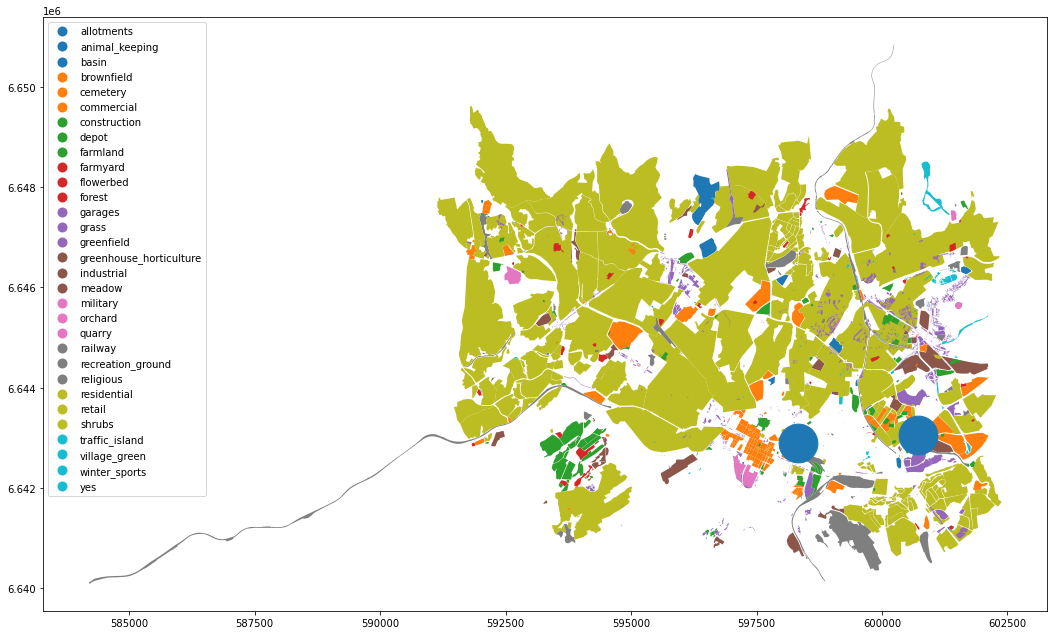

In [161]:
ax = land_use.plot(legend=True, column='landuse', figsize=(18,18))
bus_stations.plot(ax=ax, marker='o', markersize=1500)

### Plot Oslo's map

2023-07-29 22:16:26 Begin plotting the graph...
2023-07-29 22:16:27 Created edges GeoDataFrame from graph
2023-07-29 22:16:28 Finished plotting the graph
2023-07-29 22:16:28 Begin plotting the graph...
2023-07-29 22:16:28 Created edges GeoDataFrame from graph
2023-07-29 22:16:29 Finished plotting the graph


<AxesSubplot:>

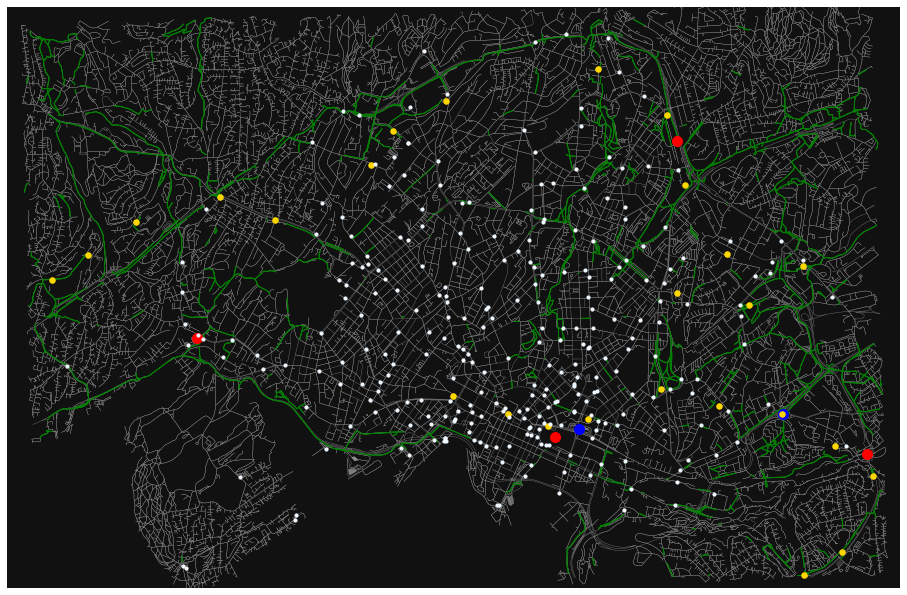

In [162]:
fig, ax = ox.plot_graph(G_bikes_projected, node_size=0, edge_linewidth=.3, figsize=(16,16), show=False)
ox.plot_graph(cycleway_graph, node_size=0, edge_color='green', ax=ax, show=False)

other_stations.plot(ax=ax, c='red', markersize = 100)
bus_stations.plot(ax=ax, c='blue', markersize = 100)

subway_stations.plot(ax=ax, c='gold', markersize = 30)

bike_sharing_stations.plot(ax=ax, c='aliceblue', markersize = 10)

#q = "landuse in ('residential', 'commercial', 'industrial', 'retail')"
#land_use.query(q).plot(column='landuse', alpha=.4, ax=ax, zorder=-1, legend=True)